In [2]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
from scipy import sparse,ndimage,interpolate
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
from multiprocessing import Pool
from functools import partial

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0
Running TARDIS 2.1...


Using TensorFlow backend.


In [767]:
rcParams['font.family']='STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'

In [630]:
flux_contrast_true = fromfile('clamato/map_128pix_deltaf.bin').reshape(128,128,128)

(array([282615.,  40881.,  41622.,  46602.,  56234.,  71381.,  98616.,
        154764., 305735., 998702.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

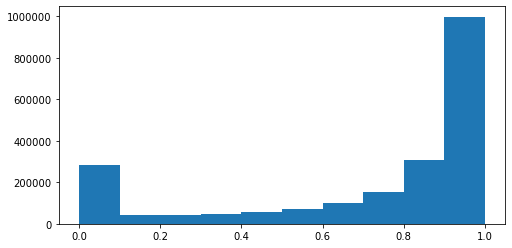

In [684]:
flux_true = (flux_contrast_true+1)/(flux_contrast_true+1).max()
hist(flux_true.flatten())

In [685]:
tau_true = -log(flux_true).reshape(1,128,128,128)

/home/zihaoli/miniconda3/envs/Tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [187]:
class load_universe:

    def __init__(self, tau,nc,bs):

        self.final_tau_RSD = tau
        self.nc = nc
        self.bs = bs

In [658]:
uni = load_universe(tau=tau_true.reshape(1,128,128,128),nc=128,bs=100)

<d_los>=2.500 Mpc/h


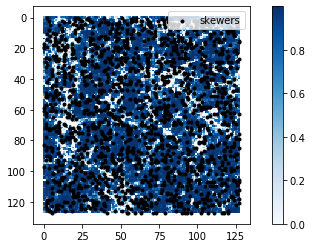

In [667]:
n_los = 1600
# n_los = 1000

n = 128
mock_lya = lya_survey(uni,2,10,sm=1,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)
print('<d_los>=%.3f Mpc/h'%(100/n_los**0.5))

In [752]:
opt_recon = reconstruct_opt(uni,mock_lya,anneal_steps=array([2.5,2,1.5,1]),k=[6,36,3,0.6],c=0.3,maxiter=[100,100,100,200])
opt_recon.initmodel()
tau_opt_recon,flux_los_opt_recon = opt_recon.run_model()
flux_opt_recon = exp(-tau_opt_recon[0])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 8224488.500000
  Number of iterations: 28
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 8205782.500000
  Number of iterations: 25
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 8170255.500000
  Number of iterations: 100
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 8085797.500000
  Number of iterations: 200
  Number of functions evaluations: 202
Total run time 126.699577


In [696]:
flux_obs = mock_lya.vals_observed
flux_contrast = flux_obs/flux_obs.mean()-1
flux_opt_recon = exp(-tau_opt_recon[0])
flux_true = exp(-tau_true)[0]

In [697]:
p = np.vstack([0.78125*mock_lya.skewers_fin.T[0], 0.78125*mock_lya.skewers_fin.T[1],0.78125*mock_lya.skewers_fin.T[2], 
               1/(mock_lya.inverse_covar[1])**0.5/mock_lya.vals_observed.mean(), flux_contrast]).T
p.tofile("pixel_data128.bin")

In [694]:
d_los = 100/(n_los)**0.5
l = n
map_n = n
num_pixels = len(mock_lya.skewers_fin.T[0])
d_los

2.5

In [698]:
# write config file
cf = open("run128.cfg", "w")
cf.write("lx = %f\n" % 100)
cf.write("ly = %f\n" % 100)
cf.write("lz = %f\n" % 100)
cf.write("num_pixels = %i\n" % num_pixels)
cf.write("map_nx = %i\n" % 128)
cf.write("map_ny = %i\n" % 128)
cf.write("map_nz = %i\n" % 128)
cf.write("corr_var_s = %f\n"%0.05)
cf.write("corr_l_perp = %f\n" % 2.5)
cf.write("corr_l_para = %f\n" % 2)
cf.write("pcg_tol = 1.0e-3\n")
cf.write("pcg_max_iter = 1000\n")
cf.write('map_path = hydro_128.bin\n')
cf.write('pixel_data_path = pixel_data128.bin')

cf.close()

In [568]:
write_run()

In [710]:
m = np.fromfile('hydro_128.bin')
flux_wiener_recon = (m.reshape(n,n,n)+1)*flux_obs.mean()

In [711]:
flux_true = exp(-tau_true)[0]
flux_true_sm = ndimage.gaussian_filter(flux_true,2.5)
flux_opt_sm = ndimage.gaussian_filter(flux_opt_recon,2.5)
flux_wiener_sm = ndimage.gaussian_filter(flux_wiener_recon,2.5)

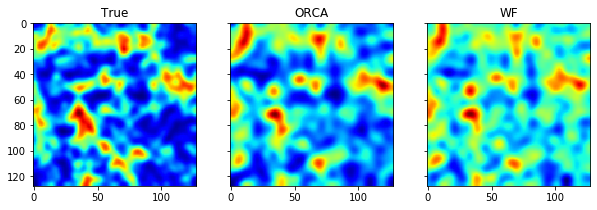

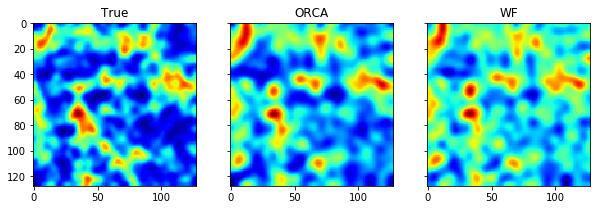

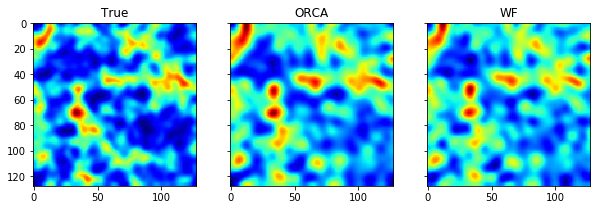

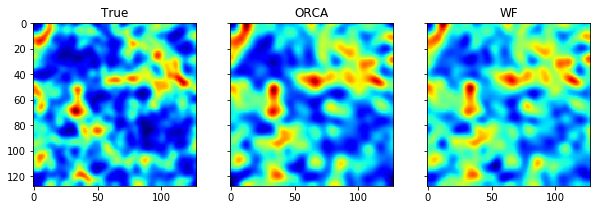

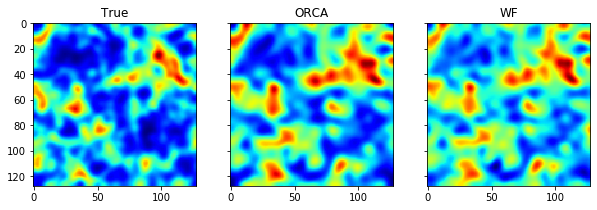

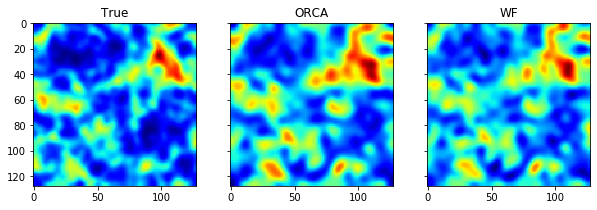

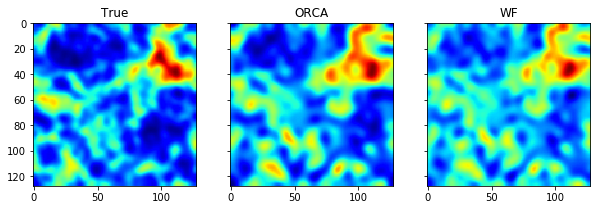

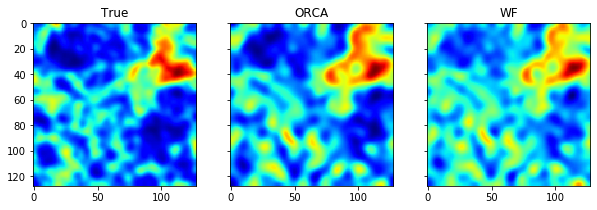

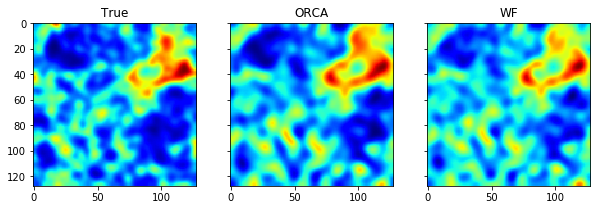

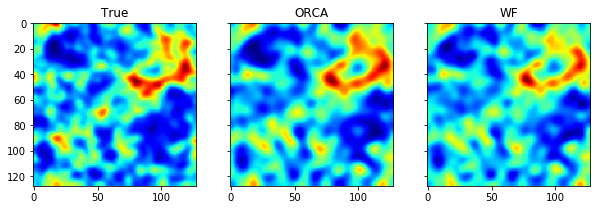

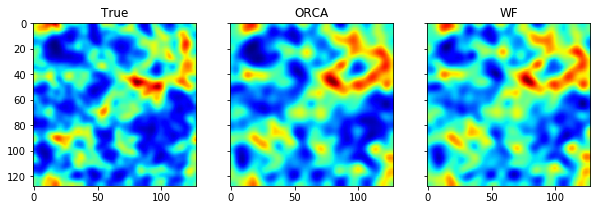

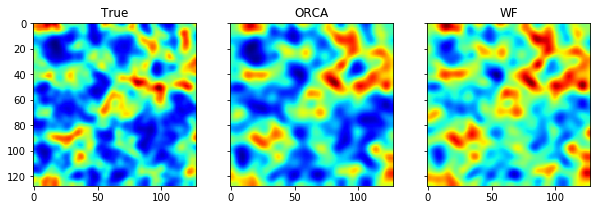

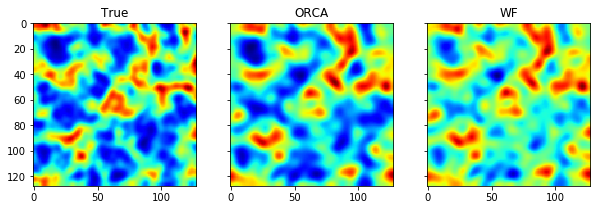

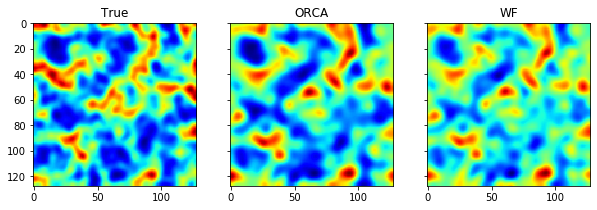

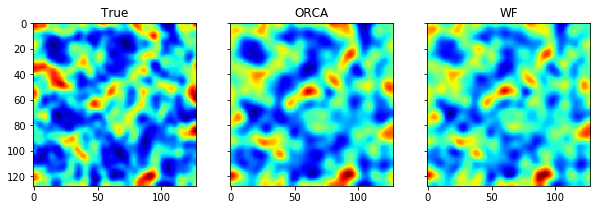

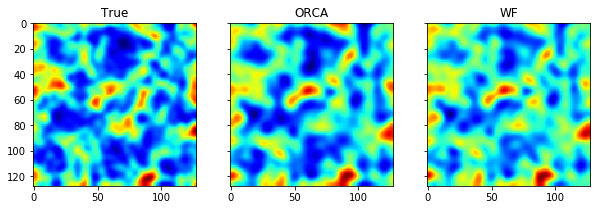

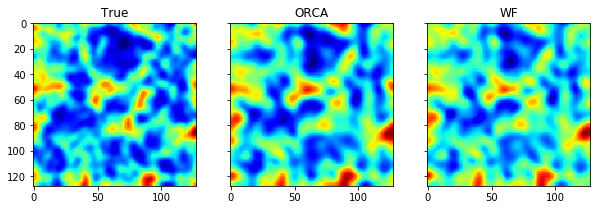

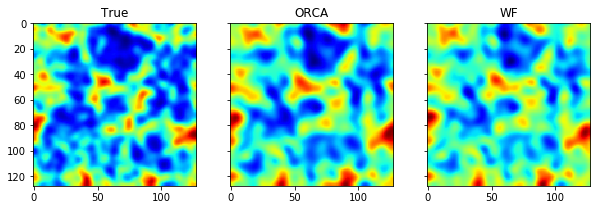

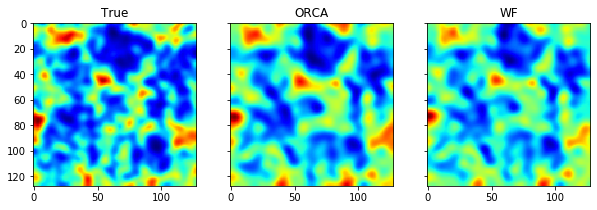

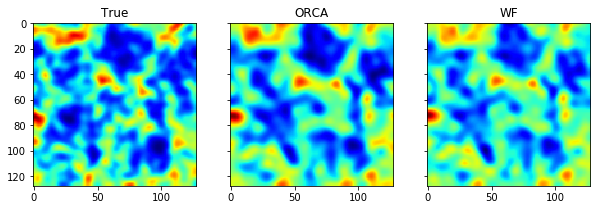

In [712]:
for i in range(0,40,2):
    fig,ax=subplots(1,3,figsize=(10,3),sharey='row')
    ax[0].imshow(flux_true_sm[...,i].T,cmap='jet_r')
    ax[0].set_title('True')
    ax[1].imshow(flux_opt_sm[...,i].T,cmap='jet_r')
    ax[1].set_title('ORCA')
    ax[2].imshow(flux_wiener_sm[...,i].T,cmap='jet_r')
    ax[2].set_title('WF')
    show()

In [245]:
flux_contrast_opt = flux_opt_recon/flux_opt_recon.mean()-1
flux_contrast_true = flux_true/flux_true.mean()-1
flux_contrast_wiener = flux_wiener_recon/flux_wiener_recon.mean()-1

In [37]:
# linear regression
def linfit(x,y):
    model = linear_model.LinearRegression()
    X=x
    Y=y

#     a = math.floor(3*len(Y)/4)
    train_X = X.reshape(-1,1)
    train_Y = Y.reshape(-1,1)
    test_X = X.reshape(-1,1)
    test_Y = Y.reshape(-1,1)

    model.fit(train_X,train_Y)
    r=model.score(test_X,test_Y)**0.5
    return model,r

In [586]:
sigma=2.5

In [757]:
x = ndimage.gaussian_filter(flux_true,sigma).flatten()
y1 = ndimage.gaussian_filter(flux_opt_recon,sigma).flatten()
y2 = ndimage.gaussian_filter(flux_wiener_recon,sigma).flatten()

m1,r1 = linfit(x,y1)
m2,r2 = linfit(x,y2)

linx = array([0.35,1.05]).reshape(-1,1)
k1 = ((m1.predict(linx)[1]-m1.predict(linx)[0])/(linx[1]-linx[0]))[0]
k2 = ((m2.predict(linx)[1]-m2.predict(linx)[0])/(linx[1]-linx[0]))[0]

## linear correction

In [833]:
y3 = (y1-m1.predict(array([0]).reshape(-1,1))[0][0])/k1
m3,r3 = linfit(x,y3)

linx = array([0.35,1.05]).reshape(-1,1)
k3 = ((m3.predict(linx)[1]-m3.predict(linx)[0])/(linx[1]-linx[0]))[0]

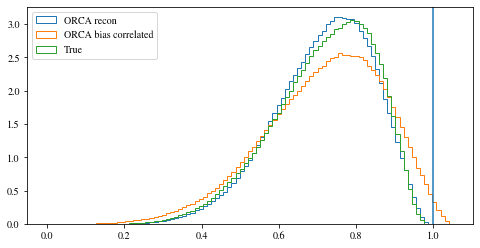

In [840]:
hist(y1,linspace(0,1.05,100),histtype='step',label='ORCA recon',density=True)
hist(y3,linspace(0,1.05,100),histtype='step',label='ORCA bias correlated',density=True)
hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),linspace(0,1.05,100),label='True',histtype='step',density=True)
legend()
axvline(1)
show()

In [39]:
def hist_h(ax,y,bins=10,c='k',lw=2,**kwargs):
    a,b=histogram(y,bins=bins,density=True)
    aa=insert(a,0,0)
    aa=append(aa,0)
    bb=append(b,b[-1])
    ax.plot(aa,bb,drawstyle='steps-pre',c=c,lw=lw,*kwargs)
    return aa,bb

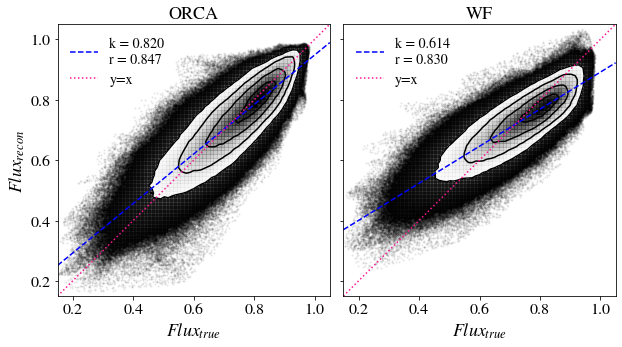

In [801]:
fig,ax = subplots(1,2,figsize=(10,5),sharex='col',sharey='row')
subplots_adjust(wspace=0.05)
corner.hist2d(x,y1,ax=ax[0],bins=bins)
corner.hist2d(x,y2,ax=ax[1],bins=bins)

# ax[0].plot(mode[0],mode[1],'s',c='yellow')
# ax[1].plot(mode[0],mode[2],'s',c='yellow')
linx = array([0.15,1.05]).reshape(-1,1)
ax[0].plot(linx,m1.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k1,r1))
ax[1].plot(linx,m2.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k2,r2))
ax[0].plot([0.15,1.05],[0.15,1.05],c='deeppink',linestyle=':',label='y=x')
ax[1].plot([0.15,1.05],[0.15,1.05],c='deeppink',linestyle=':',label='y=x')
ax[0].set_xlim(0.15,1.05)
ax[0].set_ylim(0.15,1.05)
ax[1].set_xlim(0.15,1.05)
ax[1].set_ylim(0.15,1.05)
ax[0].set_xlabel(r'$Flux_{true}$',fontsize=18)
ax[1].set_xlabel(r'$Flux_{true}$',fontsize=18)
ax[0].set_ylabel(r'$Flux_{recon}$',fontsize=18)
ax[0].set_title('ORCA',fontsize=18)
ax[1].set_title('WF',fontsize=18)
ax[0].tick_params(labelsize=16)
ax[1].tick_params(labelsize=16)
ax[0].legend(prop={'size':14},loc=2,frameon=False)
ax[1].legend(prop={'size':14},loc=2,frameon=False)
savefig('flux_scatter.pdf',bbox_inches = 'tight')

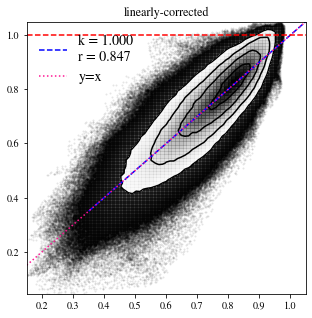

In [851]:
fig,ax = subplots(1,1,figsize=(5,5))
corner.hist2d(x,y3,ax=ax,bins=bins)
ax.set_title('linearly-corrected')
ax.plot(linx,m3.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k3,r3))
ax.plot([0.15,1.05],[0.15,1.05],c='deeppink',linestyle=':',label='y=x')
ax.set_xlim(0.15,1.05)
ax.legend(prop={'size':14},loc=2,frameon=False)
ax.axhline(1,color='red',ls='--')


In [760]:
a,b = eigen_stuff(flux_true,
                  [
                   flux_opt_recon,
                   flux_wiener_recon,
                   ],
                   kernel_sizes=[2]*4,pad = 1, rebin_size=100)

0 (128, 128, 128)
1 (128, 128, 128)


1 0
0.8909627151491882
1 1
0.8836512071662751
2 0
0.8302388568363644
2 1
0.8186404066230825
3 0
0.911443506320975
3 1
0.9038379833289546


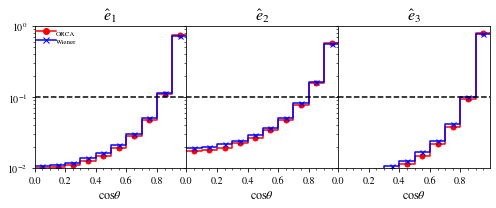

In [803]:
plot_eigenvectors(a,b,labels=[r"ORCA",'Wiener'])
savefig('eigen.pdf',bbox_inches = 'tight')

In [133]:
def classify(e,lam=0.052):
    return sum(e>lam,axis=3).flatten()

def choose_lam(e,frac_lim):
    a = -1
    b = 1
    lam = (a+b)/2
    label = classify(e,lam)
    while True:
        frac = len(label[label==3])/len(label)
        if frac-frac_lim>0:
            a = lam
            lam = (a+b)/2
        else:
            b = lam
            lam = (a+b)/2
        label = classify(e,lam)
        if abs(frac-frac_lim)<0.001:
            break
    
    return lam

In [70]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

In [771]:
sigma=2*1.28

In [772]:
pad=1
flux_true_sm = ndimage.gaussian_filter(flux_true[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(flux_true_sm)
true_label = classify(e_dm[0],choose_lam(e_dm[0],0.22))
len(true_label[true_label==3])/len(true_label)

/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:19: RuntimeWarning: invalid value encountered in true_divide
  t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:20: RuntimeWarning: invalid value encountered in true_divide
  t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:21: RuntimeWarning: invalid value encountered in true_divide
  t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:22: RuntimeWarning: invalid value encountered in true_divide
  t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:23: RuntimeWarning: invalid value encountered in true_divide
  t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:24: RuntimeWarning: invalid value encountered in true_divide
  t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d


0.21412174511191895

In [773]:
flux_wiener_sm = ndimage.gaussian_filter(flux_wiener_recon[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(flux_wiener_sm)
wiener_label = classify(e_dm[0],choose_lam(e_dm[0],0.22))

In [774]:
flux_opt_sm = ndimage.gaussian_filter(flux_opt_recon[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(flux_opt_sm)
opt_label = classify(e_dm[0],choose_lam(e_dm[0],0.22))

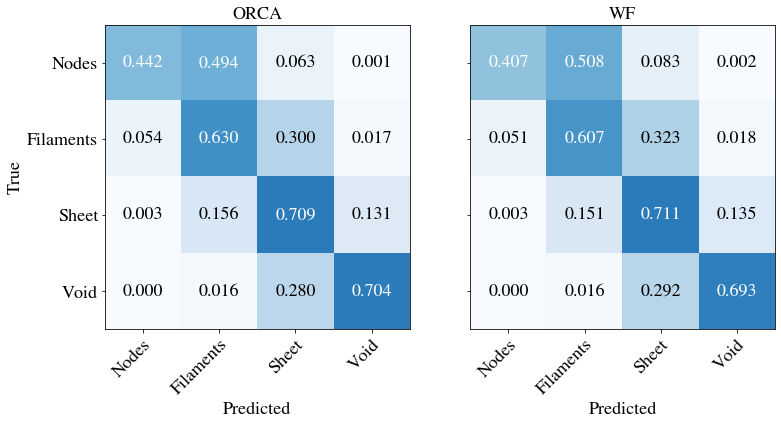

In [779]:
fig, axes = plt.subplots(1,2,sharey='row',figsize=(12,6.5))    

y_true = true_label
titles = ['ORCA','WF']
y = [opt_label,wiener_label]
# classes=np.array(["void","sheet","filaments","nodes"])
classes=np.array(["Nodes","Filaments","Sheet","Void"])

for i,ax in enumerate(axes):

#     t = titles[i]
    y_pred = y[i]
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues',vmin=0,vmax=1)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
          )
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_xticklabels() + ax.get_yticklabels(),fontsize=18)
    ax.set_xlabel('Predicted',fontsize=18)
    ax.set_title(titles[i],fontsize=18)
    normalize = True
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",fontsize=18)
axes[0].set_ylabel('True',fontsize=18)
# fig.tight_layout()
savefig('confusion_matrix.pdf',bbox_inches = 'tight',transparent=True)

In [776]:
cm_opt = confusion_matrix(true_label, opt_label)
cm_wiener = confusion_matrix(true_label, wiener_label)

In [777]:
sum(diag(cm_opt))/126**3

0.679998160345855

In [778]:
sum(diag(cm_wiener))/126**3

0.6713862793794767

## Pearson Coefficients 

In [804]:
lam1_orca,lam2_orca,lam3_orca = [b[0][0][...,i].flatten() for i in range(3)]
lam1_wiener,lam2_wiener,lam3_wiener = [b[1][0][...,i].flatten() for i in range(3)]
lam1_true,lam2_true,lam3_true = [a[0][...,i].flatten() for i in range(3)]

In [806]:
import pandas as pd

In [820]:
data_orca = pd.DataFrame({r'ORCA $\lambda_1$':lam1_orca,r'ORCA $\lambda_2$':lam2_orca,
                      r'ORCA $\lambda_3$':lam3_orca,'True $\lambda_1$':lam1_true,
                      'True $\lambda_2$':lam2_true,
                      'True $\lambda_3$':lam3_true})

In [824]:
data_wiener = pd.DataFrame({r'Wiener $\lambda_1$':lam1_wiener,r'Wiener $\lambda_2$':lam2_wiener,
                      r'Wiener $\lambda_3$':lam3_wiener,'True $\lambda_1$':lam1_true,
                      'True $\lambda_2$':lam2_true,
                      'True $\lambda_3$':lam3_true})

In [826]:
data_orca.corr('pearson').iloc[:3,3:]

,True $\lambda_1$,True $\lambda_2$,True $\lambda_3$
ORCA $\lambda_1$,0.801386,0.605237,0.507743
ORCA $\lambda_2$,0.626100,0.828122,0.654596
ORCA $\lambda_3$,0.533949,0.657106,0.886503


In [827]:
data_wiener.corr('pearson').iloc[:3,3:]

,True $\lambda_1$,True $\lambda_2$,True $\lambda_3$
Wiener $\lambda_1$,0.786867,0.597051,0.503262
Wiener $\lambda_2$,0.621877,0.813957,0.647527
Wiener $\lambda_3$,0.529086,0.651121,0.878696


In [828]:
diag(data_wiener.corr('pearson').iloc[:3,3:])

array([0.78686704, 0.81395741, 0.87869552])

In [829]:
diag(data_orca.corr('pearson').iloc[:3,3:])

array([0.80138603, 0.82812236, 0.88650281])